# Synopsis

This predictive modeling project aims to build a machine learning model to predict the presence or absence of cardiovascular disease based on 13 physiological features. The data comes from the Heart Disease dataset (https://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.

# Setup

Import all libraries and methods required for the project.

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from pickle import dump

# Load the Data

Load the data into a Pandas data frame.

In [2]:
names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                 names = names, 
                 na_values = "?")

# Describe the Data

Setup the display system to print all decimal numbers upto the third decimal place.

In [3]:
pd.set_option("precision", 3)

Look at the head and tail of the data.

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


Look at the dimensions of the data.

In [6]:
df.shape

(303, 14)

The dataset appears to have 303 rows and 14 columns.

Look at the data types of each variable in the data.

In [7]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object

Obtain descriptive statistics for the data.

In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000,303.000,303.000,303.00,303.000,303.000,303.000,303.000,303.000,303.000,303.000,299.000,301.000,303.000
mean,54.439,0.680,3.158,131.69,246.693,0.149,0.990,149.607,0.327,1.040,1.601,0.672,4.734,0.937
std,9.039,0.467,0.960,17.60,51.777,0.356,0.995,22.875,0.470,1.161,0.616,0.937,1.940,1.229
min,29.000,0.000,1.000,94.00,126.000,0.000,0.000,71.000,0.000,0.000,1.000,0.000,3.000,0.000
25%,48.000,0.000,3.000,120.00,211.000,0.000,0.000,133.500,0.000,0.000,1.000,0.000,3.000,0.000
50%,56.000,1.000,3.000,130.00,241.000,0.000,1.000,153.000,0.000,0.800,2.000,0.000,3.000,0.000
75%,61.000,1.000,4.000,140.00,275.000,0.000,2.000,166.000,1.000,1.600,2.000,1.000,7.000,2.000
max,77.000,1.000,4.000,200.00,564.000,1.000,2.000,202.000,1.000,6.200,3.000,3.000,7.000,4.000


Obtain the distribution of instances across different class labels.

In [9]:
df["num"].value_counts()

0    164
1     55
2     36
3     35
4     13
Name: num, dtype: int64

Obtain the correlations between the variables in the data.

In [10]:
df.corr(method = "pearson")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
age,1.000,-0.098,0.104,0.285,0.209,0.119,0.149,-0.394,0.092,0.204,0.162,0.363,0.127,0.223
sex,-0.098,1.000,0.010,-0.064,-0.200,0.048,0.022,-0.049,0.146,0.102,0.038,0.093,0.381,0.224
cp,0.104,0.010,1.000,-0.036,0.072,-0.040,0.068,-0.334,0.384,0.202,0.152,0.233,0.265,0.407
trestbps,0.285,-0.064,-0.036,1.000,0.130,0.175,0.147,-0.045,0.065,0.189,0.117,0.099,0.134,0.158
chol,0.209,-0.200,0.072,0.130,1.000,0.010,0.171,-0.003,0.061,0.047,-0.004,0.119,0.014,0.071
fbs,0.119,0.048,-0.040,0.175,0.010,1.000,0.070,-0.008,0.026,0.006,0.060,0.145,0.071,0.059
restecg,0.149,0.022,0.068,0.147,0.171,0.070,1.000,-0.083,0.085,0.114,0.134,0.128,0.025,0.184
thalach,-0.394,-0.049,-0.334,-0.045,-0.003,-0.008,-0.083,1.000,-0.378,-0.343,-0.386,-0.264,-0.280,-0.415
exang,0.092,0.146,0.384,0.065,0.061,0.026,0.085,-0.378,1.000,0.288,0.258,0.146,0.330,0.397
oldpeak,0.204,0.102,0.202,0.189,0.047,0.006,0.114,-0.343,0.288,1.000,0.578,0.296,0.341,0.504


Obtain the skew of each variable in the data.

In [11]:
df.skew()

age        -0.209
sex        -0.775
cp         -0.842
trestbps    0.706
chol        1.136
fbs         1.987
restecg     0.020
thalach    -0.537
exang       0.743
oldpeak     1.270
slope       0.508
ca          1.189
thal        0.244
num         1.058
dtype: float64

Use the Shapiro-Wilk test to check if the variables in the data are Gaussian.

In [12]:
# Use a significance level of 0.05

p_values = [shapiro(df[column])[1] for column in df.columns]
is_gaussian = [(p_value >= 0.05) for p_value in p_values]

check_gaussian_data = np.array([p_values, is_gaussian])
check_gaussian = pd.DataFrame(data = check_gaussian_data,
                              index = ["p_values", "is_gaussian"],
                              columns = df.columns)
check_gaussian.loc["is_gaussian"] = check_gaussian.loc["is_gaussian"].map({0: False,
                                                                           1: True})

check_gaussian

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
p_values,0.00607,3.08e-26,1.99e-19,1.8e-06,5.91e-09,5.43e-30,1.2e-24,6.99e-05,3.85e-26,8.18e-17,2.57e-21,1,1,5.59e-21
is_gaussian,False,False,False,False,False,False,False,False,False,False,False,True,True,False


The output indicates that only "ca" and "thal" are Gaussian at a 0.05 significance level. Keeping this in mind, I pick the XGBoost algorithm for modeling the problem, since this algorithm doesn't assume that its features are Gaussian.

# Visualize the Data

## Univariate Plots

Make a missing value plot to diagnose the presence of missing values in the data.

<AxesSubplot:>

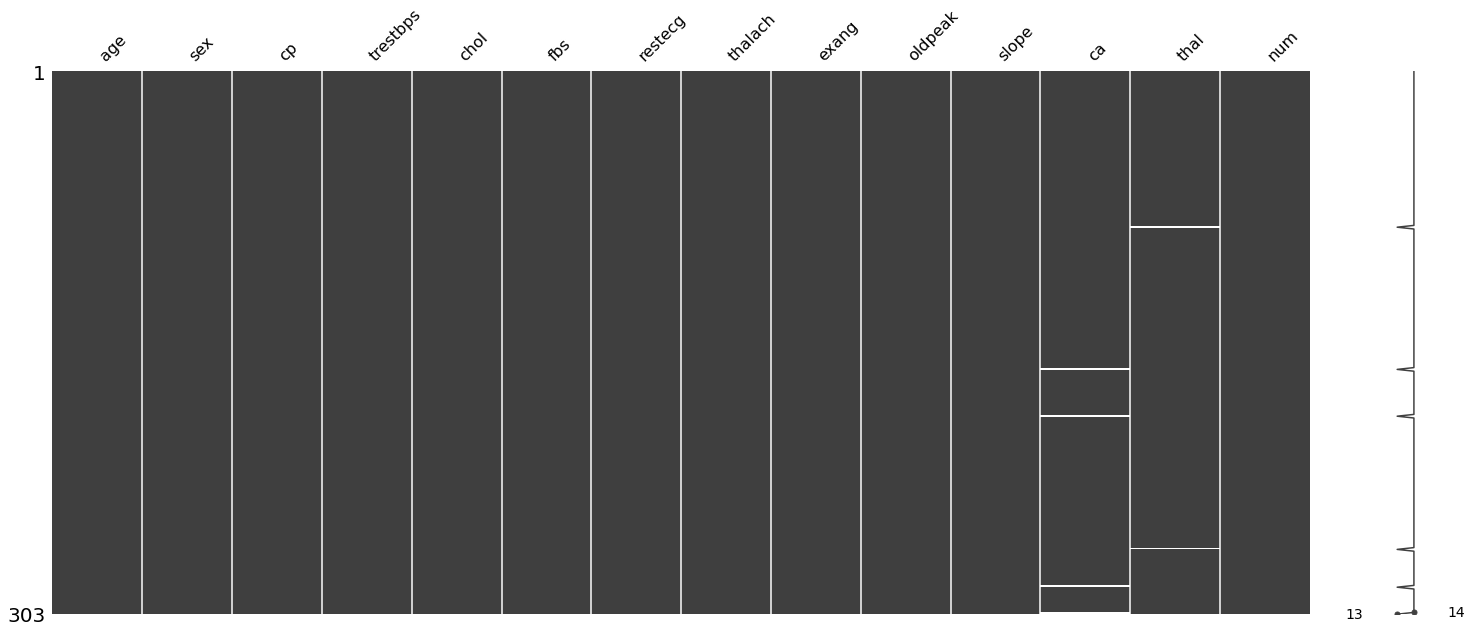

In [13]:
msno.matrix(df)

The plot's output indicates that "ca" and "thal" have missing values. Hence, imputation will have to be carried out for these two variables during preprocessing.

Make a histogram for each variable.

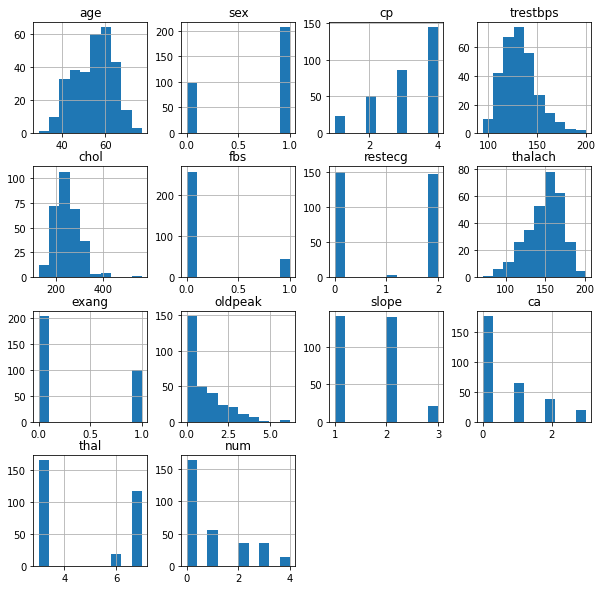

In [14]:
df.hist(figsize = [10, 10])
plt.show()

These histograms provide extremely valuable insights regarding which variables are numeric and which are categorical.

Make a density plot for each variable.

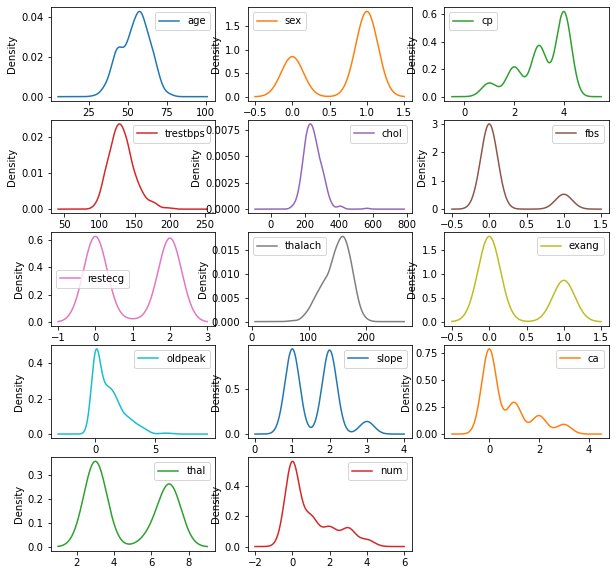

In [15]:
df.plot(kind = "density",
        subplots = True,
        layout = [5, 3],
        sharex = False,
        figsize = [10, 10])
plt.show()

Make a boxplot for each variable.

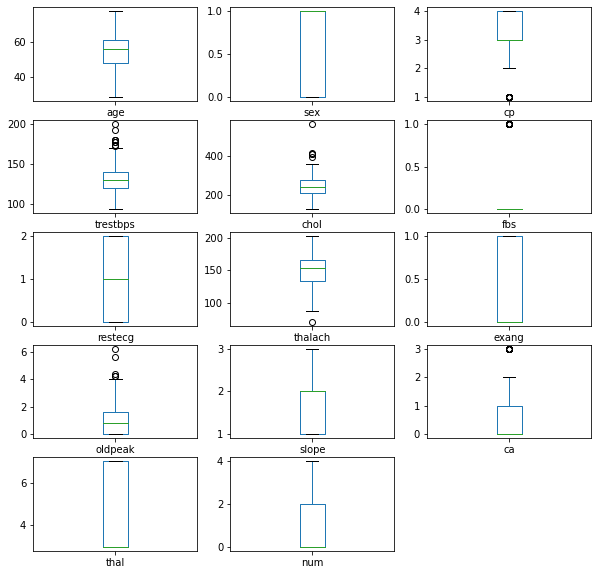

In [16]:
df.plot(kind = "box",
        subplots = True,
        layout = [5, 3],
        sharex = False,
        sharey = False,
        figsize = [10, 10])
plt.show()

## Multivariate Plots

Make a correlation matrix plot to visualize the correlation between the variables in the data.

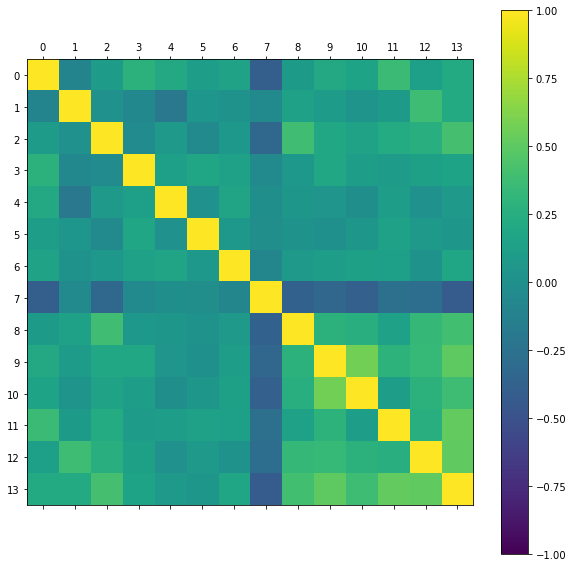

In [17]:
correlations = df.corr(method = "pearson")

fig = plt.figure(figsize = [10, 10])
ax = fig.add_subplot(111)
cax = ax.matshow(correlations,
                 vmin = -1,
                 vmax = 1)
fig.colorbar(cax)
ticks = range(14)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

The absense of any yellow or purple squares in the off-diagonal zones indicates that there is no pair of features which exhibits an extremely high correlation. This is favorable to the good performance of my model.

The numbered ticks along each axis in the above plot correspond to columns in the data frame as below.

In [18]:
pd.Series(df.columns)

0          age
1          sex
2           cp
3     trestbps
4         chol
5          fbs
6      restecg
7      thalach
8        exang
9      oldpeak
10       slope
11          ca
12        thal
13         num
dtype: object

Make a scatter plot matrix for the data frame.

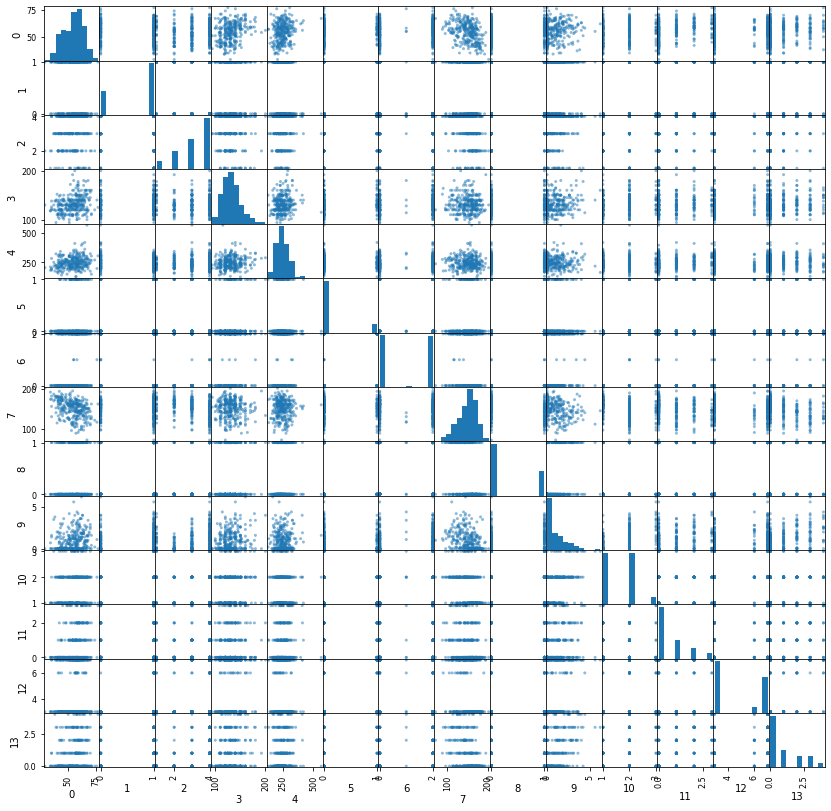

In [19]:
# Use a modified version of the data frame encoding each column as a number
# The mapping is identical to the one for the correlation matrix plot above
# This enhances the legibility of the plot labels

df_mod = pd.DataFrame(data = df.values,
                      columns = range(14))
scatter_matrix(frame = df_mod,
               figsize = [14, 14])
plt.show()

# Data Partitioning

Isolate the features and the target variable.

In [20]:
X = df
y = X.pop("num")

In [21]:
X.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [22]:
y

0      0
1      2
2      1
3      0
4      0
      ..
298    1
299    2
300    3
301    1
302    0
Name: num, Length: 303, dtype: int64

# Preprocessing

According to the dataset documentation, "Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1, 2, 3, 4) from absence (value 0)." Observe the current unique values in the target variable.

In [23]:
y.value_counts()

0    164
1     55
2     36
3     35
4     13
Name: num, dtype: int64

In its current state, the target variable has 5 unique values. I shall pool together the values 1, 2, 3 and 4 into the single value 1, to denote the presence of heart disease. I shall leave the 0 values the way they are, to denote the absence of heart disease.

In [24]:
y = y.map({0: 0,
           1: 1,
           2: 1,
           3: 1,
           4: 1})

In [25]:
y.value_counts()

0    164
1    139
Name: num, dtype: int64

I have now converted the machine learning problem to a binary classification problem, as the dataset documentation intended.

Refer to the dataset documentation as well as the histograms created above to ascertain which features are numeric and which are categorical.

In [26]:
categorical_vars = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
numeric_vars = [column for column in X.columns if (column not in categorical_vars)]

"ca" and "thal", the two variables with missing values, are both categorical variables. Hence, imputation needs to be carried out only while preprocessing categorical variables.

For numeric variables, scale the data to a mean of 0 and a standard deviation of 1.

In [27]:
numeric_transformer = StandardScaler()

For categorical variables, impute missing values using most-frequent imputation and encode variables using one-hot encoding.

In [28]:
categorical_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("one_hot", OneHotEncoder(sparse = False, handle_unknown = "ignore"))
])

Merge the numeric and categorical transformers into a single preprocessor.

In [29]:
preprocessor = ColumnTransformer(transformers = [
    ("numeric", numeric_transformer, numeric_vars),
    ("categorical", categorical_transformer, categorical_vars)
])

# Feature Selection

Extract the 10 best features from the feature list, along with the first 3 principal components. Obtain a feature union of these to make up the final feature list.

In [30]:
select_best = SelectKBest(k = 10)
pca = PCA(n_components = 3)

feature_selector = FeatureUnion(transformer_list = [
    ("select_best", select_best),
    ("pca", pca)
])

# Tune the Model Parameters

I'll be training an XGBoost classifier model. Obtain the default parameters for the pipeline.

In [31]:
default_model = XGBClassifier(use_label_encoder = False)
default_pipeline = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("feature_selector", feature_selector),
    ("model", default_model)
])

In [32]:
default_pipeline.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                    ['age', 'trestbps', 'chol', 'thalach',
                                     'oldpeak']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('one_hot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                     'slope', 'ca', 'thal'])])),
  ('feature_selector',
   FeatureUnion(transformer_list=[('select_best', SelectKBest()),
                                  ('pca', PCA(n_components=3))])),
  ('model',
   X

Make a grid of candidate parameters.

In [33]:
params = {"model__n_estimators": [750],
       "model__learning_rate": [0.00266666666, 0.00533333333, 0.008, 0.01066666666, 0.01333333333],
       "model__subsample": [0.5, 0.75, 1],
       "model__colsample_bytree": [0.4, 0.6, 0.8, 1],
       "model__max_depth": [4, 6, 8, 10]}

Perform grid search over the parameter grid.

In [34]:
grid_search = GridSearchCV(estimator = default_pipeline,
                          param_grid = params,
                          scoring = "accuracy",
                          n_jobs = 2,
                          cv = 5,
                          verbose = 3)

In [35]:
grid_search.fit(X, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   28.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 11.5min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 16.5min
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed: 17.2min finished


[03:25:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'thalach',
                                                                          'oldpeak']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
        

In [36]:
best_params = grid_search.best_params_

print("The best parameters obtained from the grid search are:")
print()
print(best_params)

The best parameters obtained from the grid search are:

{'model__colsample_bytree': 0.4, 'model__learning_rate': 0.00266666666, 'model__max_depth': 4, 'model__n_estimators': 750, 'model__subsample': 0.5}


In [37]:
best_accuracy = grid_search.best_score_

print(f"The accuracy score obtained for the best parameters is {best_accuracy}")

The accuracy score obtained for the best parameters is 0.8249180327868852


Store the best pipeline as an estimator object.

In [38]:
best_pipeline = grid_search.best_estimator_

# Save the Model

Save the model to disk so that it may be conveniently loaded later, as and when it is required to make predictions on heart disease data.

In [39]:
filename = "heart-disease-model.sav"
dump(best_pipeline, open(filename, "wb"))

In [40]:
!ls

heart-disease-model.sav     predict-heart-disease.pdf
predict-heart-disease.ipynb
